# Polynômes de chaos : application au cas de la poutre encastrée


## Résumé

Dans ce notebook, nous présentons la décomposition en chaos polynomial du cas de la poutre encastrée. Nous montrons comment créer un polynôme du chaos creux de manière simplifiée.

Ce notebook est adapté de :

* https://github.com/mbaudin47/otsupgalilee-eleve/blob/master/5-Chaos/Exercice-chaos-cantilever-beam.ipynb

# Model definition

In [1]:
import openturns as ot
import numpy as np

In [2]:
dist_E = ot.Beta(0.9, 2.2, 2.8e7, 4.8e7)
dist_E.setDescription(["E"])
F_para = ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3)  # in N
dist_F = ot.ParametrizedDistribution(F_para)
dist_F.setDescription(["F"])
dist_L = ot.Uniform(250.0, 260.0)  # in cm
dist_L.setDescription(["L"])
dist_I = ot.Beta(2.5, 1.5, 310.0, 450.0)  # in cm^4
dist_I.setDescription(["I"])

myDistribution = ot.ComposedDistribution([dist_E, dist_F, dist_L, dist_I])

In [3]:
dim_input = 4  # dimension of the input
dim_output = 1  # dimension of the output


def function_beam(X):
    E, F, L, I = X
    Y = F * (L ** 3) / (3 * E * I)
    return [Y]


g = ot.PythonFunction(dim_input, dim_output, function_beam)
g.setInputDescription(myDistribution.getDescription())

## Create a sparse polynomial chaos decomposition from least squares

Pour simplifier l'utilisation du polynôme du chaos, nous avons créé la fonction suivante qui permet de créer un polynôme du chaos creux par moindres carrés linéaires avec un nombre réduit de paramètres. 

In [4]:
def ComputeSparseLeastSquaresChaos(
    inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution
):
    """
    Create a sparse polynomial chaos with least squares.

    * Uses the enumeration rule from multivariateBasis.
    * Uses LeastSquaresStrategy to compute the coefficients from
    linear least squares.
    * Uses LeastSquaresMetaModelSelectionFactory to select the polynomials
    in the basis using least angle regression stepwise (LARS)
    * Uses FixedStrategy to keep all coefficients that LARS has selected,
    up to the given maximum total degree.

    Parameters
    ----------
    inputTrain : ot.Sample(n)
        The input training design of experiments with n points
    outputTrain : ot.Sample(n)
        The input training design of experiments with n points
    multivariateBasis : ot.Basis
        The multivariate orthogonal polynomial basis
    totalDegree : int
        The maximum total polynomial degree.
        The total polynomial degree is the sum of the marginal degrees
    myDistribution : ot.Distribution
        The distribution of the input random vector

    Returns
    -------
    result : ot.FunctionalChaosResult
        The polynomial chaos result
    """
    selectionAlgorithm = ot.LeastSquaresMetaModelSelectionFactory()
    projectionStrategy = ot.LeastSquaresStrategy(
        inputTrain, outputTrain, selectionAlgorithm
    )
    enumfunc = multivariateBasis.getEnumerateFunction()
    P = enumfunc.getStrataCumulatedCardinal(totalDegree)
    adaptiveStrategy = ot.FixedStrategy(multivariateBasis, P)
    chaosalgo = ot.FunctionalChaosAlgorithm(
        inputTrain, outputTrain, myDistribution, adaptiveStrategy, projectionStrategy
    )
    return chaosalgo

On crée la base polynomiale multivariée par tensorisation de polynômes univariés avec la règle d'énumération linéaire par défaut.

In [5]:
multivariateBasis = ot.OrthogonalProductPolynomialFactory(
    [dist_E, dist_F, dist_L, dist_I]
)

Generate an training sample of size N with MC simulation (or retrieve the design from experimental data).

In [6]:
training_sample_size = 50  # Size of the training design of experiments

inputTrain = myDistribution.getSample(training_sample_size)
outputTrain = g(inputTrain)

In [7]:
totalDegree = 5  # Maximum total polynomial degree
chaosalgo = ComputeSparseLeastSquaresChaos(
    inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution
)
chaosalgo.run()
result = chaosalgo.getResult()

La méthode `getMetaModel` retourne une fonction permettant d'évaluer le métamodèle.

In [8]:
metamodel = result.getMetaModel()
x = myDistribution.getMean()
y = metamodel(x)
y

class=Point name=Unnamed dimension=1 values=[12.3818]

## Validate the metamodel

In [9]:
def validate_polynomial_chaos(test_sample_size, myDistribution, g, metamodel):
    inputTest = myDistribution.getSample(test_sample_size)
    outputTest = g(inputTest)
    val = ot.MetaModelValidation(inputTest, outputTest, metamodel)
    Q2 = val.computePredictivityFactor()[0]
    graph = val.drawValidation()
    graph.setTitle("Q2=%.2f%%" % (Q2 * 100))
    return graph

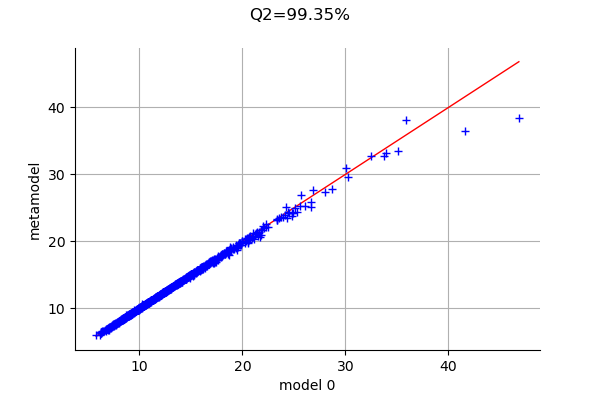

In [10]:
test_sample_size = 1000
validate_polynomial_chaos(test_sample_size, myDistribution, g, metamodel)

In [11]:
def printCoefficientsTable(polynomialChaosResult):
    """
    Print the coefficients of the polynomial chaos.

    Parameters
    ----------
    enumerate_function : ot.EnumerateFunction
        The enumerate function.
    polynomialChaosResult : ot.PolynomialChaosResult
        The polynomial chaos result.
    """
    basis = polynomialChaosResult.getOrthogonalBasis()
    coefficients = result.getCoefficients()
    enumerate_function = basis.getEnumerateFunction()
    indices = polynomialChaosResult.getIndices()
    nbcoeffs = indices.getSize()
    print("# Indice, Multi-indice, Total degree : Value")
    for k in range(nbcoeffs):
        multiindex = enumerate_function(indices[k])
        degree = sum(multiindex)
        c = coefficients[k][0]
        print("#%d, %s (%s) : %s" % (k, multiindex, degree, c))
    return

In [12]:
printCoefficientsTable(result)

# Indice, Multi-indice, Total degree : Value
#0, [0,0,0,0] (0) : 12.5763292154894
#1, [1,0,0,0] (1) : -1.5318239273441774
#2, [0,1,0,0] (1) : 3.6841842271444643
#3, [0,0,1,0] (1) : 0.3927939547816703
#4, [0,0,0,1] (1) : -1.0093985802396985
#5, [2,0,0,0] (2) : 0.1801708714864712
#6, [1,1,0,0] (2) : -0.41879290488963783
#7, [1,0,1,0] (2) : -0.03230615601332438
#8, [1,0,0,1] (2) : 0.14206205858629578
#9, [0,2,0,0] (2) : -0.0937769807044938
#10, [0,1,0,1] (2) : -0.3421292354037207
#11, [0,0,1,1] (2) : -0.04076652473080944
#12, [0,0,0,2] (2) : 0.07100996749674612
#13, [2,0,0,1] (3) : -0.0256574131770888
#14, [1,2,0,0] (3) : 0.025653013738311012
#15, [1,1,0,1] (3) : 0.04728641608241961
#16, [1,0,1,1] (3) : 0.006763764775810558
#17, [0,2,1,0] (3) : -0.11716804576263637
#18, [0,1,0,2] (3) : 0.027029691865426003
#19, [2,0,2,1] (5) : 0.004016661262748303
#20, [1,0,4,0] (5) : -0.02150967985028953
#21, [1,0,3,1] (5) : 0.013669027744158957
#22, [0,1,2,2] (5) : 0.0001506124069474681
#23, [0,0,4,1] (

## Create a sparse polynomial chaos decomposition from integration

In [13]:
def ComputeFullIntegrationChaos(
    function, multivariateBasis, totalDegree, myDistribution
):
    """
    Create a full polynomial chaos with integration based on Gaussian quadrature.

    * Uses the enumeration rule from multivariateBasis.
    * Uses GaussProductExperiment to create a design of experiments using
    a given total degree.
    * Uses IntegrationStrategy to compute the coefficients using
    integration.
    * Uses FixedStrategy to keep all coefficients.

    When the number of input variables
    or the required marginal degree is large, the design of experiments is
    very large.

    Parameters
    ----------
    function : ot.Function
        The function to create the metamodel from.
    multivariateBasis : ot.Basis
        The multivariate orthogonal polynomial basis
    totalDegree : int
        The total polynomial degree.
        The total degree is the sum of the marginal degrees.
    myDistribution : ot.Distribution
        The distribution of the input random vector

    Returns
    -------
    result : ot.FunctionalChaosResult
        The polynomial chaos result
    """
    enumfunc = multivariateBasis.getEnumerateFunction()
    P = enumfunc.getStrataCumulatedCardinal(totalDegree)
    adaptiveStrategy = ot.FixedStrategy(multivariateBasis, P)
    distribution_measure = multivariateBasis.getMeasure()
    totalDegreeList = [totalDegree] * dim_input
    experiment = ot.GaussProductExperiment(distribution_measure, totalDegreeList)
    projectionStrategy = ot.IntegrationStrategy(experiment)
    chaosalgo = ot.FunctionalChaosAlgorithm(
        function, myDistribution, adaptiveStrategy, projectionStrategy
    )
    return chaosalgo

In [14]:
totalDegree = 3  # Total polynomial degree
chaosalgo = ComputeFullIntegrationChaos(g, multivariateBasis, totalDegree, myDistribution)
chaosalgo.run()
result = chaosalgo.getResult()

La méthode `getMetaModel` retourne une fonction permettant d'évaluer le métamodèle.

In [15]:
metamodel = result.getMetaModel()
x = myDistribution.getMean()
y = metamodel(x)
y

class=Point name=Unnamed dimension=1 values=[12.3556]

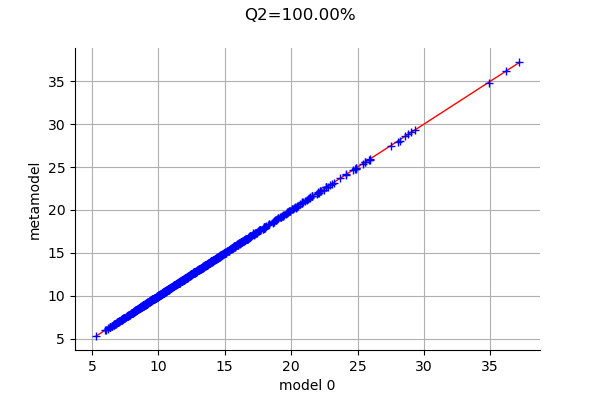

In [16]:
test_sample_size = 1000
validate_polynomial_chaos(test_sample_size, myDistribution, g, metamodel)

In [17]:
printCoefficientsTable(result)

# Indice, Multi-indice, Total degree : Value
#0, [0,0,0,0] (0) : 12.624574383988882
#1, [1,0,0,0] (1) : -1.5516056616766554
#2, [0,1,0,0] (1) : 3.787372314985828
#3, [0,0,1,0] (1) : 0.4286212020415066
#4, [0,0,0,1] (1) : -0.9991446552969345
#5, [2,0,0,0] (2) : 0.19864856394404595
#6, [1,1,0,0] (2) : -0.46548169847708365
#7, [1,0,1,0] (2) : -0.05267908949435183
#8, [1,0,0,1] (2) : 0.12279847675172534
#9, [0,2,0,0] (2) : 3.772294976389645e-13
#10, [0,1,1,0] (2) : 0.12858636060529427
#11, [0,1,0,1] (2) : -0.2997433965723932
#12, [0,0,2,0] (2) : 0.0043396474265375296
#13, [0,0,1,1] (2) : -0.03392229869625174
#14, [0,0,0,2] (2) : 0.08610252410058268
#15, [3,0,0,0] (3) : 9.89108029572251e-15
#16, [2,1,0,0] (3) : 0.05959456917989608
#17, [2,0,1,0] (3) : 0.006744384695416182
#18, [2,0,0,1] (3) : -0.01572161127260066
#19, [1,2,0,0] (3) : -4.660855035254485e-14
#20, [1,1,1,0] (3) : -0.015803726847425596
#21, [1,1,0,1] (3) : 0.03683954302346673
#22, [1,0,2,0] (3) : -0.0005333582988140354
#23, [1,